In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import ZeroPadding2D, Dropout, Flatten, add, Reshape
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Nadam
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16

## Read train and test files

In [2]:
train_df = pd.read_csv('../input/severstal-steel-defect-detection/train.csv')

print(train_df.shape)

(7095, 3)


In [3]:
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


## Combine defected and no-defect images

In [4]:
# Data Pre-Processing
TRAIN_PATH = '../input/severstal-steel-defect-detection/train_images/'
TEST_PATH = '../input/severstal-steel-defect-detection/test_images/'

train_flist = os.listdir(TRAIN_PATH) 

image_defects = train_df['ImageId'].unique().tolist()
image_no_defects=[item for item in train_flist if item not in image_defects]

#df_bin is the dataframe with label defect based on train_df 
df_bin = train_df.drop_duplicates(subset=['ImageId'], keep='last').copy()
df_bin.loc[:, 'defect_label'] = 1

df_noDefect_bin = pd.DataFrame(image_no_defects,columns=['ImageId'])
df_noDefect_bin.loc[:, 'defect_label'] = 0

frames = [df_bin[['ImageId', "defect_label"]], df_noDefect_bin]
df = pd.concat(frames).reset_index(drop=True)
print(df.shape)
print(df['defect_label'].value_counts())

(12568, 2)
1    6666
0    5902
Name: defect_label, dtype: int64


In [5]:
df.head(1)

,ImageId,defect_label
0,0002cc93b.jpg,1


## Split train data, load and resave images

In [6]:
nb_images = df.shape[0]
df_train, df_test = train_test_split(df, test_size=0.3, 
                                                    stratify = df['defect_label'], 
                                                    random_state=2021)

df_train, df_val = train_test_split(df_train, test_size=0.25, 
                                                  stratify = df_train['defect_label'],
                                                  random_state=2021) 

# 0.25 x 0.8 = 0.2

IMAGE_SIZE = 224

def load_img(code, base, resize=True):
    path = f'{base}/{code}'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    return img

def validate_path(path):
    if not os.path.exists(path):
        os.makedirs(path)

train_path = '../tmp/train'
validate_path(train_path)
val_path = '../tmp/val'
validate_path(val_path)
test_path = '../tmp/test'
validate_path(test_path)

def process_img(df, train_path):
    #read image, resize and save
    for code in tqdm(df['ImageId']):
        img = load_img(
            code,
            base='../input/severstal-steel-defect-detection/train_images'
        )
        path = code.replace('.jpg', '')
        cv2.imwrite(f'{train_path}/{path}.png', img)

    df['ImageId'] = df['ImageId'].apply(lambda x: x.replace('.jpg', '.png'))
    return df
df_train = process_img(df_train,train_path)

df_val = process_img(df_val,val_path)

df_test = process_img(df_test,test_path)

print(df_train.shape,df_val.shape,df_test.shape)
print(df_train['defect_label'].value_counts())
print(df_val['defect_label'].value_counts())
print(df_test['defect_label'].value_counts())

100%|██████████| 3771/3771 [01:12<00:00, 51.91it/s]

(6597, 2) (2200, 2) (3771, 2)
1    3499
0    3098
Name: defect_label, dtype: int64
1    1167
0    1033
Name: defect_label, dtype: int64
1    2000
0    1771
Name: defect_label, dtype: int64



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Define ImageDataGenerator and data augmentation

In [7]:
BATCH_SIZE = 32

# Using original generator
data_generator = ImageDataGenerator(
        zoom_range=0.1,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,
        rotation_range=10,
        height_shift_range=0.05,
        width_shift_range=0.05,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255.,
    )
val_generator = ImageDataGenerator(
        rescale=1/255.
    )

train_gen = data_generator.flow_from_dataframe(
        df_train, 
        directory='../tmp/train',
        x_col='ImageId', 
        y_col='defect_label', 
        class_mode='raw',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        )

val_gen =  val_generator.flow_from_dataframe(
        df_val, 
        directory='../tmp/val',
        x_col='ImageId', 
        y_col='defect_label', 
        class_mode='raw',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        )
test_gen =  val_generator.flow_from_dataframe(
        df_test, 
        directory='../tmp/test',
        x_col='ImageId', 
        y_col='defect_label', 
        class_mode='raw',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=False
        )


Found 6597 validated image filenames.
Found 2200 validated image filenames.
Found 3771 validated image filenames.


## Define Model

In [8]:
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)

def build_model():
    
    model = VGG16(weights='imagenet',include_top=False, input_shape=input_shape)
    # add new classifier layers
    for layer in model.layers:
        layer.trainable = False

    flat1 = Flatten()(model.layers[-1].output)
    den1 = Dense(256, activation= 'relu')(flat1)
    output = Dense(1, activation='sigmoid')(den1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)

    model.compile(
        loss='binary_crossentropy',
        optimizer= Adam(learning_rate = 0.001),
        metrics=['accuracy']
    )
    

    return model
model = build_model()
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_______________________________________________________

## Model training

In [9]:
epochs = 50

import math
# We take the ceiling because we do not drop the remainder of the batch
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))

steps_per_epoch = compute_steps_per_epoch(df_train.shape[0])
validation_steps = compute_steps_per_epoch(df_val.shape[0])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, min_lr=1e-6)

mc = ModelCheckpoint(
    'model.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [10]:
history = model.fit(
    train_gen,
    steps_per_epoch= steps_per_epoch,
    validation_data=val_gen,
    validation_steps= validation_steps,
    epochs=epochs,
    callbacks=[es,mc,reduce_lr]
)

Epoch 1/50
207/207 [==============================] - ETA: 0s - loss: 0.6612 - accuracy: 0.6799
Epoch 00001: val_accuracy improved from -inf to 0.69182, saving model to model.h5
207/207 [==============================] - 94s 452ms/step - loss: 0.6612 - accuracy: 0.6799 - val_loss: 0.5413 - val_accuracy: 0.6918
Epoch 2/50
207/207 [==============================] - ETA: 0s - loss: 0.4772 - accuracy: 0.7606
Epoch 00002: val_accuracy improved from 0.69182 to 0.79500, saving model to model.h5
207/207 [==============================] - 91s 440ms/step - loss: 0.4772 - accuracy: 0.7606 - val_loss: 0.4326 - val_accuracy: 0.7950
Epoch 3/50
207/207 [==============================] - ETA: 0s - loss: 0.4579 - accuracy: 0.7693
Epoch 00003: val_accuracy improved from 0.79500 to 0.80045, saving model to model.h5
207/207 [==============================] - 91s 442ms/step - loss: 0.4579 - accuracy: 0.7693 - val_loss: 0.4258 - val_accuracy: 0.8005
Epoch 4/50
207/207 [==============================] - ETA:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


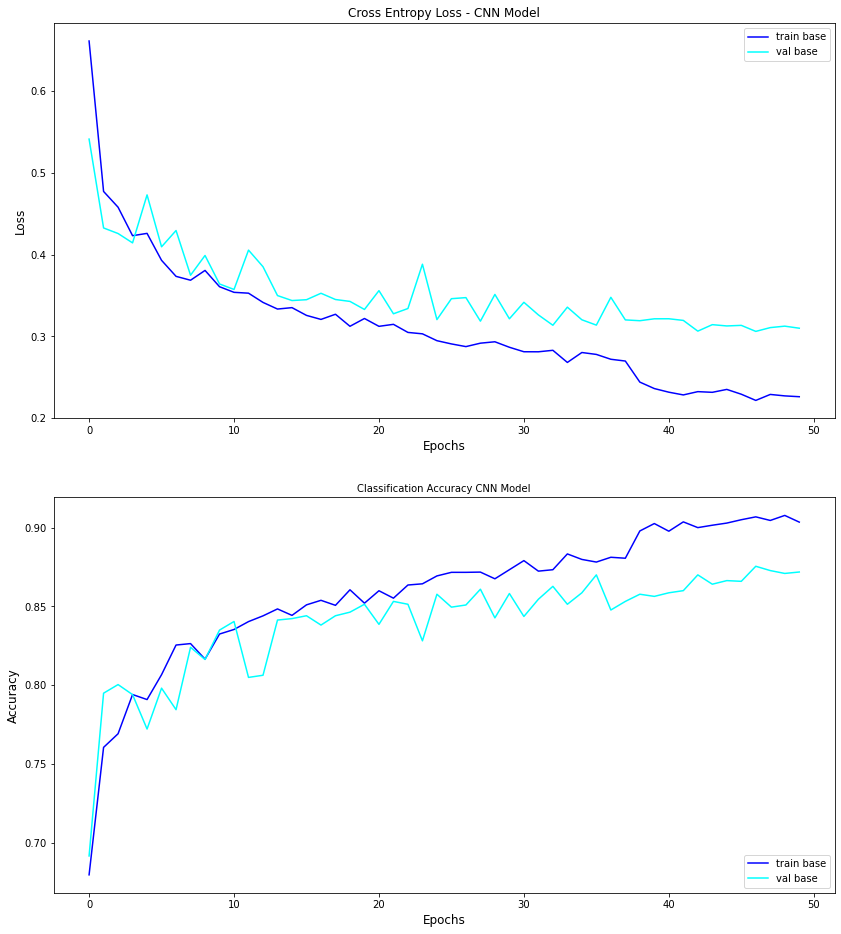

In [11]:
def history_plot(model_id, history1):
	plt.figure(figsize=(14,16)) 
	# plot loss
	plt.subplot(2, 1, 1)
	plt.title('Cross Entropy Loss - ' + model_id, fontsize = 12)
	plt.plot(history1.history['loss'], color='blue', label='train base')
	plt.plot(history1.history['val_loss'], color='cyan', label='val base')
	plt.xlabel("Epochs",fontsize = 12)
	plt.ylabel("Loss", fontsize = 12)
	plt.legend(loc='upper right')

	# plot accuracy
	plt.subplot(2, 1, 2)
	plt.title('Classification Accuracy ' + model_id, fontsize = 10)
	plt.plot(history1.history['accuracy'], color='blue', label='train base')
	plt.plot(history1.history['val_accuracy'], color='cyan', label='val base')
	plt.xlabel("Epochs", fontsize = 12)
	plt.ylabel("Accuracy", fontsize = 12)
	plt.legend(loc='lower right')

	plt.show()

print(history.history.keys())

history_plot('CNN Model', history)

In [12]:
# Save results as CSV files
model.load_weights('model.h5')
#saved_model = load_model(checkpoint_best_model)

category_names = ["No Defect", "Defect"]

y_test = df_test['defect_label']

STEP_SIZE_TEST = compute_steps_per_epoch(y_test.shape[0])
print('predicting...')

predictions = model.predict(
    test_gen,
    steps = STEP_SIZE_TEST,
    verbose=1)

y_pred = (predictions > 0.5).astype("int32")

# classification report
report_string = classification_report(y_test, y_pred, target_names=category_names)
print(report_string)

predicting...
118/118 [==============================] - 14s 121ms/step
              precision    recall  f1-score   support

   No Defect       0.88      0.87      0.87      1771
      Defect       0.89      0.89      0.89      2000

    accuracy                           0.88      3771
   macro avg       0.88      0.88      0.88      3771
weighted avg       0.88      0.88      0.88      3771



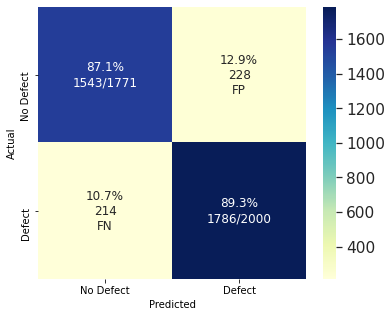

In [13]:
def plot_cm(y_true, y_pred, figsize=(6,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            elif i<j:
                annot[i, j] = '%.1f%%\n%d\nFP' % (p, c)
            else:
                annot[i, j] = '%.1f%%\n%d\nFN' % (p, c)
    #cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm = pd.DataFrame(cm, index=category_names, columns=category_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(font_scale=1.4)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax, annot_kws={"fontsize":12})

plot_cm(y_test, y_pred, figsize=(6,5))

ROC AUC=0.950


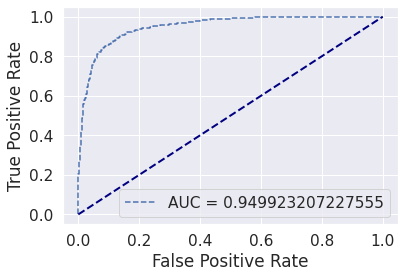

In [14]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# calculate scores
auc = roc_auc_score(y_test, predictions)
# summarize scores
print('ROC AUC=%.3f' % (auc))
# calculate roc curves

ns_fpr, ns_tpr, _ = roc_curve(y_test, predictions)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label="AUC = "+ str(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [15]:
model.save('severstal-classification-VGG.h5', save_format="h5")
